# Parameters for Latent Heat
Here, I explore suitable paramaters to include for latent and sensible heat so they both only depend on temperature (or sensible heat is constant).

In [1]:
import copy
import sys
import os
# REMOTE - So can access functions in isca_tools which is in home/Isca directory
# sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))
# LOCAL - So can access functions in isca_tools which is in StAndrews/Isca
sys.path.append(os.environ['PWD'])
import isca_tools
from isca_tools.utils.moist_physics import moist_static_energy, clausius_clapeyron_factor, sphum_sat, get_density, virtual_temp, saturation_vapor_pressure
from isca_tools.utils.constants import kappa, L_v, c_p, c_p_water, rho_water, Stefan_Boltzmann, R, R_v
from isca_tools.utils import area_weighting, annual_mean, annual_time_slice, anom_from_annual_mean, print_ds_var_list
from isca_tools.papers.byrne_2021 import get_quant_ind
from isca_tools.thesis.adiabat_theory import get_temp_adiabat, get_temp_adiabat_surf
from isca_tools.convection.simple_betts_miller import lcl_temp, ref_temp_above_lcl, get_temp_ref
from isca_tools.convection import dry_profile_pressure, moist_profile, potential_temp
import isca_tools.utils.fourier as fourier
from isca_tools.utils.radiation import get_heat_capacity
from isca_tools.plot import colored_line
from isca_tools.thesis.surface_energy_budget import get_temp_fourier, gamma_linear_approx, swdn_from_temp_fourier
from isca_tools.thesis.hottest_date import get_var_extrema_date
from isca_tools.plot import label_subplots
from isca_tools.utils.calculus import grad_y
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy.optimize
from tqdm import tqdm
from scipy import optimize, ndimage
import warnings
# Use custom matplotlib style for publishing
plt.style.use('/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')
plt.rcParams['lines.linewidth'] = 0.8

In [196]:
# Load dataset - one at surface and one in free troposphere
var_keep = ['temp', 'sphum', 't_surf', 'swdn_sfc', 'lwup_sfc', 'lwdn_sfc', 
            'flux_lhe', 'flux_t', 'drag_q', 'drag_t', 'q_surf', 'rho', 'p_atm', 'ps', 'q_surf', 'ucomp', 'vcomp', 'w_atm']  

# #No WISHE experiment
# exp_dir = 'aquaplanet/no_wishe/'
# exp_name = 'k=1'

# #WISHE experiment
exp_dir = 'aquaplanet/latent_heat_temp_only/'
exp_name = 'base'

mixed_layer_depth = isca_tools.load_namelist(exp_dir+exp_name)['mixed_layer_nml']['depth']
use_virtual_temp = isca_tools.load_namelist(exp_dir+exp_name)['surface_flux_nml']['use_virtual_temp']
p_surface_approx = isca_tools.load_namelist(exp_dir+exp_name)['spectral_dynamics_nml']['reference_sea_level_press']/100

lat_range = slice(25, 90)               # only consider NH and outside deep tropics
use_time_start = 360*2
ds_use = isca_tools.load_dataset(exp_dir + exp_name)
try:
    ds_use = ds_use[var_keep]
except KeyError:
    remove_keys = []
    for key in var_keep:
        if key not in ds_use:
            print(f'Removing {key} from var_keep')
            remove_keys += [key]
    for key in remove_keys:
        var_keep.remove(key)
    ds_use = ds_use[var_keep]
ds_base = ds_use.sel(time=slice(use_time_start, np.inf)).sel(lat=lat_range)      # only keep after spin up
ds_base = ds_base.sel(pfull=p_surface_approx, method='nearest').load()

In [197]:
# If true, will save all figures to desktop - option to save specific figures later on.
save_fig = False
# if publishing figure, use high dpi
publish_fig = True

ar = 4/3        # aspect ratio (width/height)
im_sz = 1.4     # larger makes images larger, keeping ar the same
# Details required for Journal of Climate Figures
low_dpi = 100
dpi = {'monochrome': 1100, 'combination': 800, 'halftone': 300}
width = {'one_col': 3.2, 'two_col': 5.5}        # width in inches 
save_pad_inches = 0.05

# Default parameters
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ax_linewidth = plt.rcParams['axes.linewidth']

In [199]:
# Take Annual Zonal Average
def get_annual_zonal_av(var):
    var_av = annual_mean(var).median(dim='lon')       # median to remove outlier influence
    return var_av.assign_coords(time=(var_av.time - var_av.time.min()).astype(int))

sigma_near_surf = float(ds_base.pfull)/p_surface_approx
ds_base['rh'] = ds_base.sphum / sphum_sat(ds_base.temp, ds_base.ps*sigma_near_surf)
ds_base['temp_diseqb'] = ds_base.t_surf - ds_base.temp
ds = get_annual_zonal_av(ds_base).load()

## Latent Heat Decomposition
The [equation](https://github.com/jduffield65/Isca/blob/b9249275469583c1723f12ac62333067f9460fea/isca_source/src/coupler/surface_flux.F90#L598) used for latent heat flux by Isca is:
$LH = L_v C_q\rho |v|(q^*_s - q_a)$
where $C_q$ is the moisture drag coefficient, $\rho$ is the lowest level air density, $|v|$ is the lowest level horizontal wind speed, $q^*_s = q^*(T_s, p_s)$ is the saturation specific humidity at the surface, $q_a$ is the lowest level specific humidity. In general, $s$ is surface and $a$ is lowest model level.

If we re-write $q_a = r_aq^*(T_a, p_a) = r_aq^*(T_s - T_{diseqb}, \sigma p_s)$ where $T_{diseqb} = T_s-T_a$ is the surface-atmosphere disequilibrium, and $r$ is relative humidity, then:

$LH = L_v C_q\rho |v|(q^*_s - r_aq^*(T_s - T_{diseqb}, \sigma p_s))$

and Latent Heat is really only a function of wind speed, surface temperature, relative humidity and surface-atmosphere disequilibrium.

### Drag Coefficient, $C_q$

In [200]:
month_ticks = (np.arange(15,12*30+15,30), ['J','F','M','A','M','J','J','A','S','O','N','D'])

def av_func(var):
    # Take median in time, then area weighted mean in latitude
    return float(area_weighting(var.median(dim='time')).mean())


def plot_var_anom(var, var_label, var_unit, percentage_anomaly=False, var_plot=None, ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(im_sz*width['one_col'], im_sz*width['one_col']/ar), sharex=True)
    else:
        fig = None
    if var_plot is None:
        var_av = av_func(var)
        if percentage_anomaly:
            var_plot = 100*(var-var_av)/var_av
            var_anom_unit = '%'
        else:
            var_plot = var - var_av
            var_anom_unit = var_unit
        var_plot.plot(ax=ax, cbar_kwargs={'label': f"${var_label} - \overline{'{'+var_label+'}'}$ [{var_anom_unit}]"})
        ax.set_title(f"$\overline{'{'+var_label+'}'} = {var_av:.3g}$" + ('' if var_unit is None else (f"[{var_unit}]")))
    else:
        var_av = av_func(var_plot)
        var_plot.plot(ax=ax, cbar_kwargs={'label': f"{var_label} [{var_unit}]"})
        ax.set_title('')
    ax.set_ylabel('')
    ax.invert_yaxis()
    ax.set_yticks(*month_ticks)
    ax.set_xlabel('Latitude [deg]')
    return None, var_av

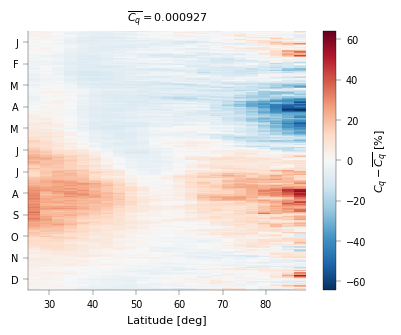

In [201]:
fig, av_drag = plot_var_anom(ds.drag_q, 'C_q', None, percentage_anomaly=True)

### Wind Speed


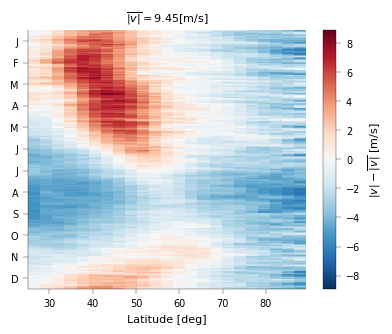

In [202]:
fig, av_w_atm = plot_var_anom(ds.w_atm, '|v|', 'm/s')

### Relative Humidity

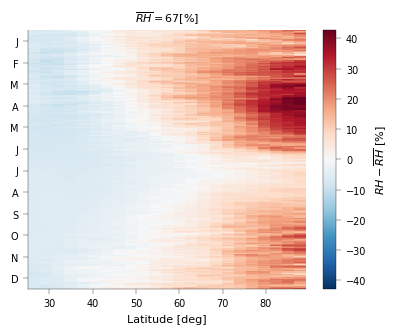

In [203]:
fig, av_rh = plot_var_anom(ds.rh*100, 'RH', '%')
av_rh = av_rh/100

### Surface-Atmosphere Disequilibrium, $T_{s-a}$

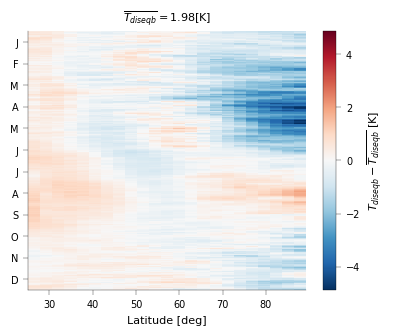

In [204]:
fig, av_temp_diseqb = plot_var_anom(ds.temp_diseqb, 'T_{diseqb}', 'K')

### Density, $\rho$
The [equation](https://github.com/jduffield65/Isca/blob/b9249275469583c1723f12ac62333067f9460fea/isca_source/src/coupler/surface_flux.F90#L579) for density used by Isca is:

$\rho = \frac{p_a}{RT_{a, v}}$

where $T_{a, v}$ is the virtual temperature at $p_a$ and $p_a = \sigma_a p_s$ where $p_s$ is the surface pressure which varies throughout the year (gets lower at hot times).

Here, we approximate it so it only depends on $T_s$ by:

$\rho(T_s) \approx \frac{\sigma_a p_{s, approx}}{R(T_s-\overline{T_{diseqb}})}$

where $p_{s, approx} = 1000hPa$ is the reference sea level pressure. This only gives a 3% error which seems reasonable.

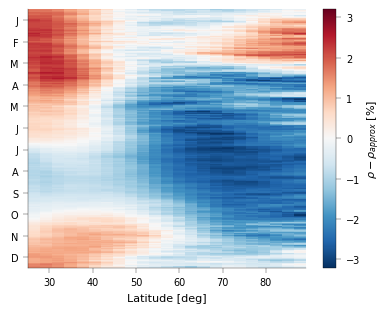

In [205]:
# sigma_near_surf = float(ds.pfull)/p_surface_approx
rho_approx = get_density(ds.t_surf-av_temp_diseqb, ds.pfull*100)
fig, _ = plot_var_anom(None, '$\\rho-\\rho_{approx}$', '%', var_plot=100*(ds.rho-rho_approx)/ds.rho)

### Pressure
As well as in $\rho$, surface pressure also appears in the equation for $q^*_s = q^*(T_s, p_s)$ and $q^*_a = q^*(T_s-T_{diseqb}, \sigma p_s)$. Below, we see the effect of setting this to a constant of 1000hPa. 

This only gives a 3% error which seems reasonable.

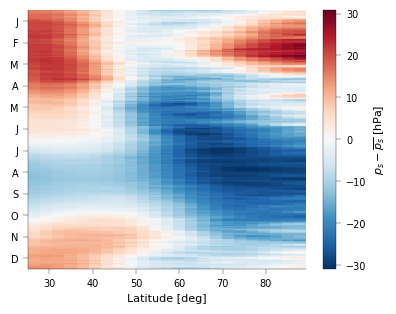

In [206]:
plot_var_anom(None, '$p_s-\overline{p_s}$', 'hPa', var_plot=ds.ps/100-p_surface_approx);

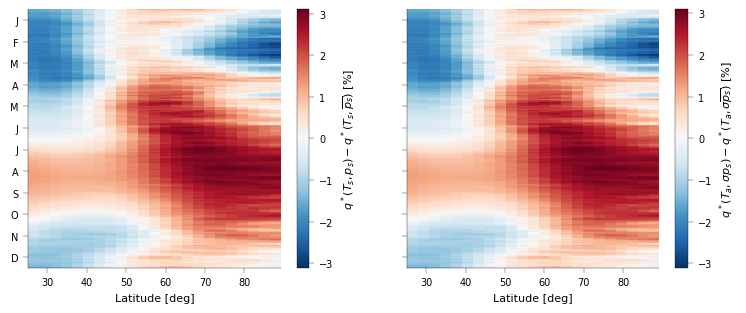

In [207]:
fig, ax = plt.subplots(1, 2, figsize=(2*im_sz*width['one_col'], im_sz*width['one_col']/ar), sharex=True, sharey=True)
plot_var_anom(None, '$q^*(T_s, p_s) - q^*(T_s, \overline{p_s})$', '%', 
                       var_plot=100*(sphum_sat(ds.t_surf, ds.ps) - sphum_sat(ds.t_surf, p_surface_approx*100))/sphum_sat(ds.t_surf, ds.ps), 
                       ax=ax[0]);
plot_var_anom(None, '$q^*(T_a, \sigma p_s) - q^*(T_a, \sigma \overline{p_s})$', '%', 
                       var_plot=100*(sphum_sat(ds.temp, ds.p_atm) - sphum_sat(ds.temp, ds.pfull*100))/sphum_sat(ds.temp, ds.p_atm), 
                       ax=ax[1]);

## Final Latent Heat Approximation
Below I first show that the equation used is pretty good, but there is an error that comes just through averaging the individual variables first. This averaging error is especially apparent at high latitudes, when the non-linearity is more important.

The difference between the black solid and dotted lines arise due to slightly different methods for [computing saturation vapor pressure](https://github.com/jduffield65/Isca/blob/b9249275469583c1723f12ac62333067f9460fea/isca_source/src/coupler/surface_flux.F90#L418) I think. But, they are close enough.

The plot below that shows that the variation in wind throughout the year is the major determinant of the non-temperature dependent variation in latent heat.

In [225]:
def get_latent_heat(temp_surf, temp_diseqb, rh, p_surf, wind_speed, drag_coef, sigma=sigma_near_surf, virtual=False):
    p_a = p_surf*sigma
    temp_a = temp_surf - temp_diseqb
    sphum_a = rh * sphum_sat(temp_a, p_a)
    if virtual:
        rho = get_density(temp_a, p_a, sphum_a)
    else:
        rho = get_density(temp_a, p_a)
    return L_v * drag_coef * rho * wind_speed * (sphum_sat(temp_surf, p_surf) - sphum_a)

lh_calc = {'av_first':  get_annual_zonal_av(get_latent_heat(ds_base.t_surf, ds_base.temp_diseqb, ds_base.rh, ds_base.ps, 
                                                            ds_base.w_atm, ds_base.drag_q, virtual=use_virtual_temp)), 
           'av_last': get_latent_heat(ds.t_surf, ds.temp_diseqb, ds.rh, ds.ps, ds.w_atm, ds.drag_q, virtual=use_virtual_temp),
           'const_pressure': get_annual_zonal_av(get_latent_heat(ds_base.t_surf, ds_base.temp_diseqb, ds_base.rh, p_surface_approx*100, 
                                                                 ds_base.w_atm, ds_base.drag_q)),
           'const_rh': get_annual_zonal_av(get_latent_heat(ds_base.t_surf, ds_base.temp_diseqb, av_rh, ds_base.ps, ds_base.w_atm, ds_base.drag_q)), 
           'const_temp_diseqb': get_annual_zonal_av(get_latent_heat(ds_base.t_surf, av_temp_diseqb, av_rh, ds_base.ps, ds_base.w_atm, 
                                                                    ds_base.drag_q)), 
           'const_wind': get_annual_zonal_av(get_latent_heat(ds_base.t_surf, ds_base.temp_diseqb, ds_base.rh, ds_base.ps, av_w_atm, ds_base.drag_q)), 
           'const_drag': get_annual_zonal_av(get_latent_heat(ds_base.t_surf, ds_base.temp_diseqb, ds_base.rh, ds_base.ps, ds_base.w_atm, av_drag)), 
           'final': get_annual_zonal_av(get_latent_heat(ds_base.t_surf, av_temp_diseqb, av_rh, p_surface_approx*100, av_w_atm, av_drag))}

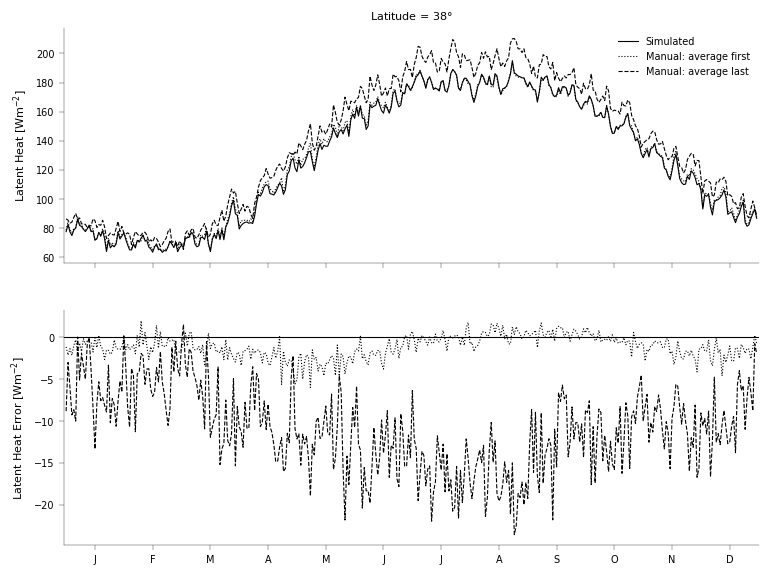

In [253]:
ind_lat_plot = 4
fig, ax = plt.subplots(2, 1, figsize=(2*im_sz*width['one_col'], 2*im_sz*width['one_col']/ar), sharex=True)
ax[0].plot(ds.time, ds.flux_lhe.isel(lat=ind_lat_plot), color='k', label='Simulated')
ax[0].plot(ds.time, lh_calc['av_first'].isel(lat=ind_lat_plot), linestyle=':', label='Manual: average first', color='k')
ax[0].plot(ds.time, lh_calc['av_last'].isel(lat=ind_lat_plot), linestyle='--', label='Manual: average last', color='k')
ax[1].axhline(0, color='k')
ax[1].plot(ds.time, ds.flux_lhe.isel(lat=ind_lat_plot) - lh_calc['av_first'].isel(lat=ind_lat_plot), linestyle=':', color='k')
ax[1].plot(ds.time, ds.flux_lhe.isel(lat=ind_lat_plot) - lh_calc['av_last'].isel(lat=ind_lat_plot), linestyle='--', color='k')
ax[0].legend()
ax[0].set_xticks(*month_ticks)
ax[0].set_xlim(-1, 360)
ax[0].set_ylabel('Latent Heat [Wm$^{-2}$]')
ax[1].set_ylabel('Latent Heat Error [Wm$^{-2}$]')
ax[0].set_title(f'Latitude = {ds.lat[ind_lat_plot]:.2g}$\degree$');

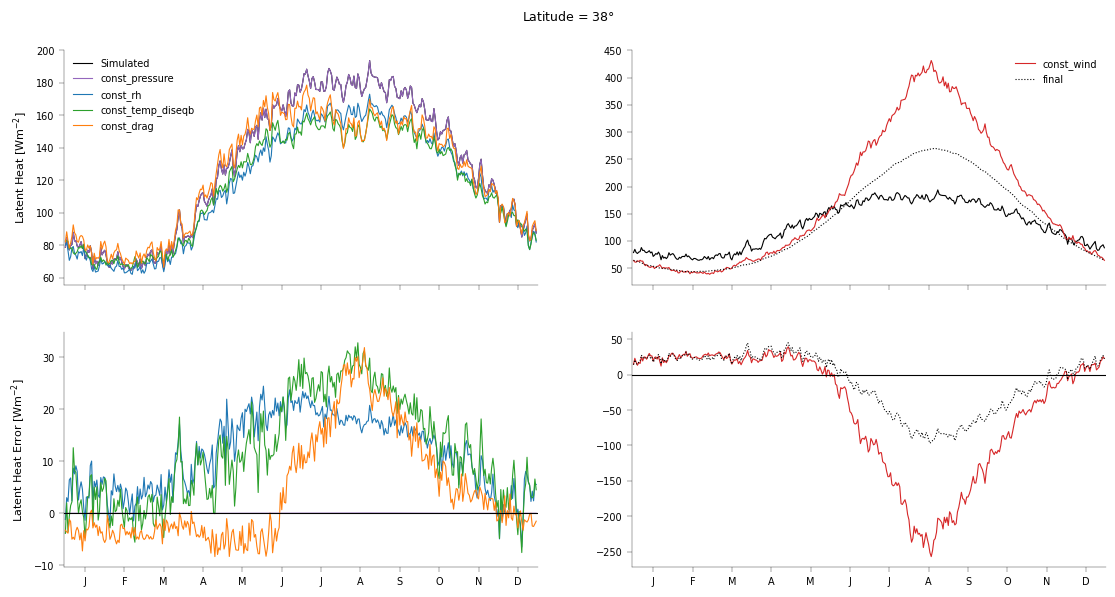

In [254]:
fig, ax = plt.subplots(2, 2, figsize=(3*im_sz*width['one_col'], 2*im_sz*width['one_col']/ar), sharex=True)
ax[0, 0].plot(ds.time, lh_calc['av_first'].isel(lat=ind_lat_plot), color='k', label='Simulated')
ax[0, 1].plot(ds.time, lh_calc['av_first'].isel(lat=ind_lat_plot), color='k')
colors_approx = {'rh': default_colors[0], 'pressure': default_colors[4], 'temp_diseqb': default_colors[2], 'wind': default_colors[3], 
                 'drag': default_colors[1], 'final': 'k'}

for key in lh_calc:
    if 'av' in key:
        continue
    # if 'av' in key or 'pressure' in key:
    #     continue
    if ('wind' in key) or ('final' in key):
        ax[0, 1].plot(ds.time, lh_calc[key].isel(lat=ind_lat_plot), color=colors_approx[key.replace('const_', '')], 
           linestyle='-' if 'const' in key else ':', label=key)
        ax[1, 1].plot(ds.time, lh_calc['av_first'].isel(lat=ind_lat_plot)-lh_calc[key].isel(lat=ind_lat_plot), 
                   color=colors_approx[key.replace('const_', '')], 
                   linestyle='-' if 'const' in key else ':', label=key)
    else:
        ax[0, 0].plot(ds.time, lh_calc[key].isel(lat=ind_lat_plot), color=colors_approx[key.replace('const_', '')], 
                   linestyle='-' if 'const' in key else ':', label=key)
        ax[1, 0].plot(ds.time, lh_calc['av_first'].isel(lat=ind_lat_plot)-lh_calc[key].isel(lat=ind_lat_plot), 
                   color=colors_approx[key.replace('const_', '')], 
                   linestyle='-' if 'const' in key else ':', label=key)
ax[1, 0].axhline(0, color='k')
ax[1, 1].axhline(0, color='k')
ax[0, 0].legend()
ax[0, 1].legend()
ax[0, 0].set_xticks(*month_ticks)
ax[0, 0].set_xlim(-1, 360)
ax[0, 0].set_ylabel('Latent Heat [Wm$^{-2}$]')
ax[1, 0].set_ylabel('Latent Heat Error [Wm$^{-2}$]')
fig.suptitle(f'Latitude = {ds.lat[ind_lat_plot]:.2g}$\degree$', fontsize=9, y=0.94);

### Variation with Latitude
Below we see that using the constant values indicated in this notebook, we over-estimate the latent heat in summer, because we use a larger wind. We also under-estimate the latent heat in winter of the lower latitudes because we under-estimate the wind speed here. 

The over-estimate of relative humidity and under-estimate of $T_{diseqb}$ in summer of the subtropics, both act to somewhat counteract the over-estimate of the latent heat in the summer of the low latitudes.

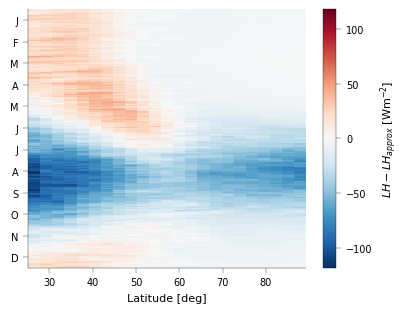

In [255]:
plot_var_anom(None, '$LH - LH_{approx}$', 'Wm$^{-2}$', var_plot=lh_calc['av_first']-lh_calc['final']);

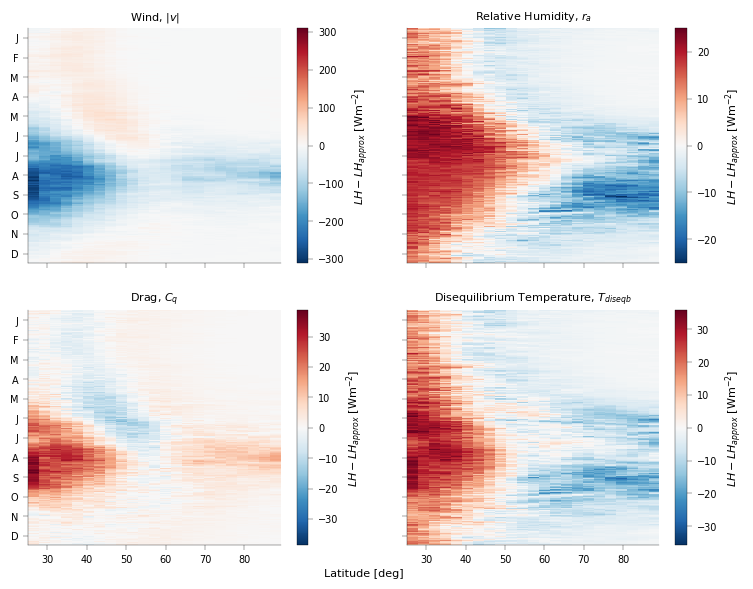

In [256]:
fig, ax = plt.subplots(2, 2, figsize=(2*im_sz*width['one_col'], 2*im_sz*width['one_col']/ar), sharex=True, sharey=True)
plot_var_anom(None, '$LH - LH_{approx}$', 'Wm$^{-2}$', var_plot=lh_calc['av_first']-lh_calc['const_wind'], ax=ax[0, 0])
plot_var_anom(None, '$LH - LH_{approx}$', 'Wm$^{-2}$', var_plot=lh_calc['av_first']-lh_calc['const_drag'], ax=ax[1, 0])
plot_var_anom(None, '$LH - LH_{approx}$', 'Wm$^{-2}$', var_plot=lh_calc['av_first']-lh_calc['const_rh'], ax=ax[0, 1])
plot_var_anom(None, '$LH - LH_{approx}$', 'Wm$^{-2}$', var_plot=lh_calc['av_first']-lh_calc['const_temp_diseqb'], ax=ax[1, 1])
ax[0, 0].set_title('Wind, $|v|$')
ax[1, 0].set_title('Drag, $C_q$')
ax[0, 1].set_title('Relative Humidity, $r_a$')
ax[1, 1].set_title('Disequilibrium Temperature, $T_{diseqb}$')
for ax_use in ax.flatten():
    ax_use.set_xlabel('')
fig.supxlabel('Latitude [deg]', fontsize=8, y=0.06);

### Seasonal Cycle
Below, we see that if we only include $T_s$ dependence, the broad seasonal variation of LH at all latitudes is still captured.

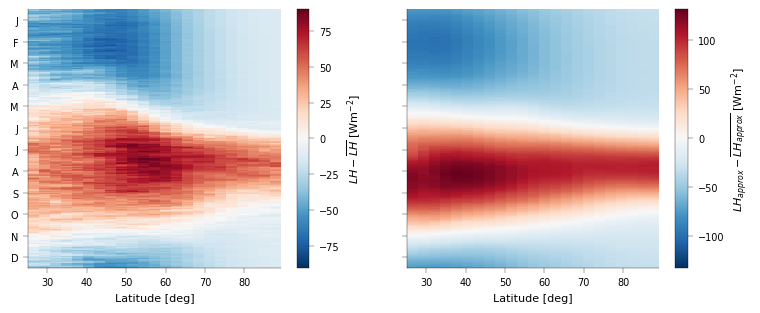

In [299]:
fig, ax = plt.subplots(1, 2, figsize=(2*im_sz*width['one_col'], im_sz*width['one_col']/ar), sharex=True, sharey=True)
plot_var_anom(None, '$LH - \overline{LH}$', 'Wm$^{-2}$', var_plot=lh_calc['av_first']-lh_calc['av_first'].mean(dim='time'), ax=ax[0])
plot_var_anom(None, '$LH_{approx} - \overline{LH_{approx}}$', 'Wm$^{-2}$', var_plot=lh_calc['final']-lh_calc['final'].mean(dim='time'), ax=ax[1]);

## Sensible Heat

The [equation](https://github.com/jduffield65/Isca/blob/b9249275469583c1723f12ac62333067f9460fea/isca_source/src/coupler/surface_flux.F90#L583) used for sensible heat flux by Isca is:
$SH = c_p C_t\rho(T_a, p_a) |v|\bigg(T_s - T_a\bigg(\frac{p_s}{p_a}\bigg)^{\kappa}\bigg)$

This can be written as $SH = c_p C_t\rho(T_s - T_{diseqb}, \sigma_a p_s) |v|\bigg(T_s(1-\sigma_a^{-\kappa}) + T_{diseqb}\sigma_a^{-\kappa}\bigg)$

### Drag
The only new variable that can vary sensible but not latent heat is the drag coefficient, $C_t$. It seems that this is actually the same as the latent heat drag coefficent.

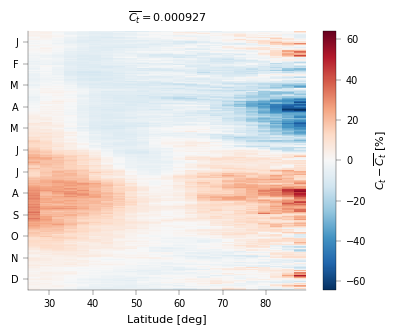

In [257]:
fig, av_drag_t = plot_var_anom(ds.drag_t, 'C_t', None, percentage_anomaly=True)

## Final Sensible Heat Approximation
Below I first show that the equation used is pretty good, but there is an error that comes just through averaging the individual variables first. This averaging error is especially apparent at high latitudes, when the non-linearity is more important.

The plot below that shows that the variation in wind and disequilibrium temperature throughout the year are the major determinants of the non-temperature dependent variation in sensible heat.

In [274]:
def get_sensible_heat(temp_surf, temp_diseqb, p_surf, wind_speed, drag_coef, sigma=sigma_near_surf, virtual=False, rh=None):
    p_a = p_surf*sigma
    temp_a = temp_surf - temp_diseqb
    if virtual:
        sphum_a = rh * sphum_sat(temp_a, p_a)
        rho = get_density(temp_a, p_a, sphum_a)
    else:
        rho = get_density(temp_a, p_a)
    return c_p * drag_coef * rho * wind_speed * (temp_surf*(1-sigma**(-kappa)) +temp_diseqb*sigma**(-kappa))

sh_calc = {'av_first':  get_annual_zonal_av(get_sensible_heat(ds_base.t_surf, ds_base.temp_diseqb, ds_base.ps, 
                                                              ds_base.w_atm, ds_base.drag_t, virtual=use_virtual_temp, rh=ds_base.rh)), 
           'av_last': get_sensible_heat(ds.t_surf, ds.temp_diseqb, ds.ps, ds.w_atm, ds.drag_t, virtual=use_virtual_temp, rh=ds.rh),
           'const_pressure': get_annual_zonal_av(get_sensible_heat(ds_base.t_surf, ds_base.temp_diseqb, p_surface_approx*100,  
                                                                   ds_base.w_atm, ds_base.drag_t)), 
           'const_temp_diseqb': get_annual_zonal_av(get_sensible_heat(ds_base.t_surf, av_temp_diseqb, ds_base.ps, 
                                                              ds_base.w_atm, ds_base.drag_t)), 
           'const_wind': get_annual_zonal_av(get_sensible_heat(ds_base.t_surf, ds_base.temp_diseqb, ds_base.ps, 
                                                               av_w_atm, ds_base.drag_t)), 
           'const_drag': get_annual_zonal_av(get_sensible_heat(ds_base.t_surf, ds_base.temp_diseqb, ds_base.ps, 
                                                              ds_base.w_atm, av_drag_t)), 
           'final': get_annual_zonal_av(get_sensible_heat(ds_base.t_surf, av_temp_diseqb, p_surface_approx*100, 
                                                          av_w_atm, av_drag_t))}

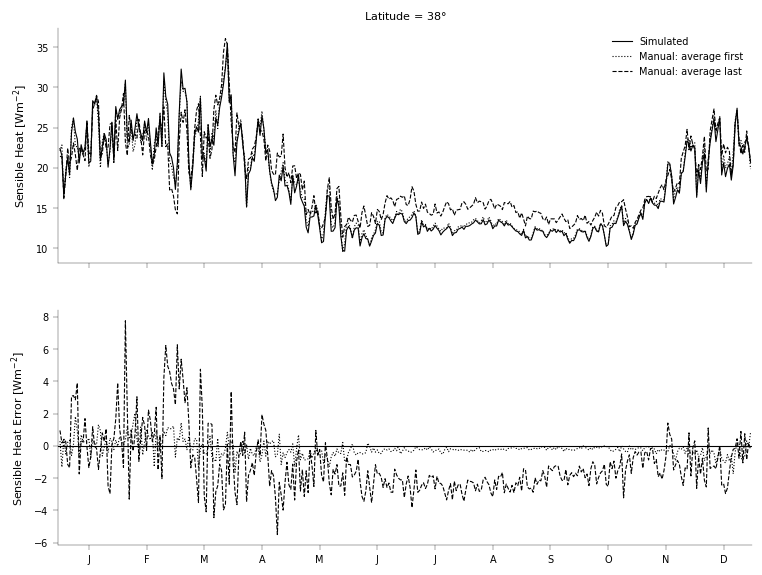

In [275]:
fig, ax = plt.subplots(2, 1, figsize=(2*im_sz*width['one_col'], 2*im_sz*width['one_col']/ar), sharex=True)
ax[0].plot(ds.time, ds.flux_t.isel(lat=ind_lat_plot), color='k', label='Simulated')
ax[0].plot(ds.time, sh_calc['av_first'].isel(lat=ind_lat_plot), linestyle=':', label='Manual: average first', color='k')
ax[0].plot(ds.time, sh_calc['av_last'].isel(lat=ind_lat_plot), linestyle='--', label='Manual: average last', color='k')
ax[1].axhline(0, color='k')
ax[1].plot(ds.time, ds.flux_t.isel(lat=ind_lat_plot) - sh_calc['av_first'].isel(lat=ind_lat_plot), linestyle=':', color='k')
ax[1].plot(ds.time, ds.flux_t.isel(lat=ind_lat_plot) - sh_calc['av_last'].isel(lat=ind_lat_plot), linestyle='--', color='k')
ax[0].legend()
ax[0].set_xticks(*month_ticks)
ax[0].set_xlim(-1, 360)
ax[0].set_ylabel('Sensible Heat [Wm$^{-2}$]')
ax[1].set_ylabel('Sensible Heat Error [Wm$^{-2}$]')
ax[0].set_title(f'Latitude = {ds.lat[ind_lat_plot]:.2g}$\degree$');

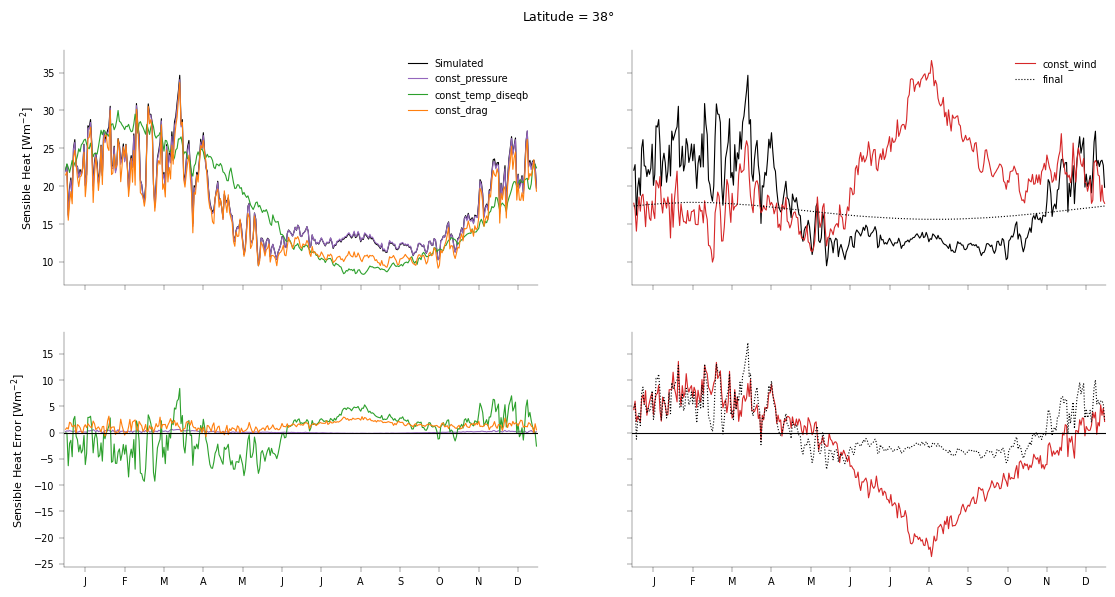

In [276]:
fig, ax = plt.subplots(2, 2, figsize=(3*im_sz*width['one_col'], 2*im_sz*width['one_col']/ar), sharex=True, sharey='row')
ax[0, 0].plot(ds.time, sh_calc['av_first'].isel(lat=ind_lat_plot), color='k', label='Simulated')
ax[0, 1].plot(ds.time, sh_calc['av_first'].isel(lat=ind_lat_plot), color='k')

for key in sh_calc:
    if 'av' in key:
        continue
    # if 'av' in key or 'pressure' in key:
    #     continue
    if ('wind' in key) or ('final' in key):
        ax[0, 1].plot(ds.time, sh_calc[key].isel(lat=ind_lat_plot), color=colors_approx[key.replace('const_', '')], 
           linestyle='-' if 'const' in key else ':', label=key)
        ax[1, 1].plot(ds.time, sh_calc['av_first'].isel(lat=ind_lat_plot)-sh_calc[key].isel(lat=ind_lat_plot), 
                   color=colors_approx[key.replace('const_', '')], 
                   linestyle='-' if 'const' in key else ':', label=key)
    else:
        ax[0, 0].plot(ds.time, sh_calc[key].isel(lat=ind_lat_plot), color=colors_approx[key.replace('const_', '')], 
                   linestyle='-' if 'const' in key else ':', label=key)
        ax[1, 0].plot(ds.time, sh_calc['av_first'].isel(lat=ind_lat_plot)-sh_calc[key].isel(lat=ind_lat_plot), 
                   color=colors_approx[key.replace('const_', '')], 
                   linestyle='-' if 'const' in key else ':', label=key)
ax[1, 0].axhline(0, color='k')
ax[1, 1].axhline(0, color='k')
ax[0, 0].legend()
ax[0, 1].legend()
ax[0, 0].set_xticks(*month_ticks)
ax[0, 0].set_xlim(-1, 360)
ax[0, 0].set_ylabel('Sensible Heat [Wm$^{-2}$]')
ax[1, 0].set_ylabel('Sensible Heat Error [Wm$^{-2}$]')
fig.suptitle(f'Latitude = {ds.lat[ind_lat_plot]:.2g}$\degree$', fontsize=9, y=0.94);

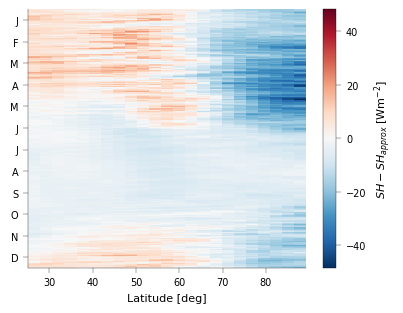

In [277]:
plot_var_anom(None, '$SH - SH_{approx}$', 'Wm$^{-2}$', var_plot=sh_calc['av_first']-sh_calc['final']);

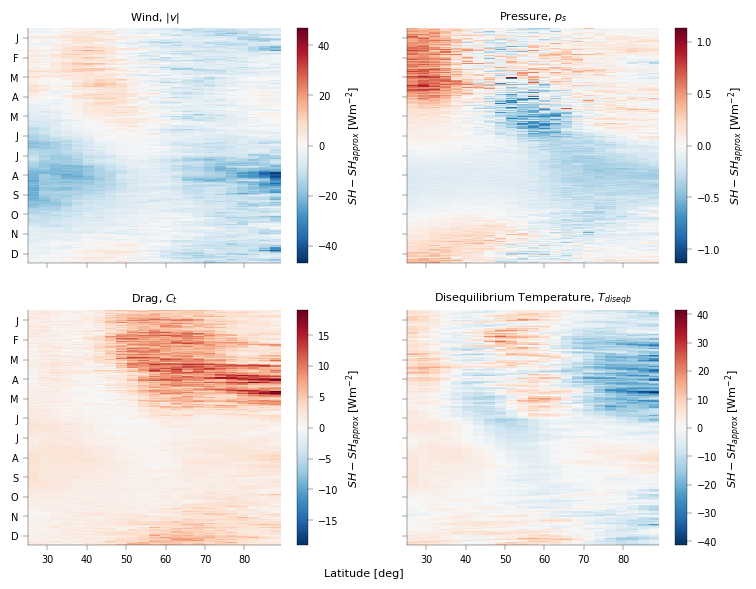

In [297]:
fig, ax = plt.subplots(2, 2, figsize=(2*im_sz*width['one_col'], 2*im_sz*width['one_col']/ar), sharex=True, sharey=True)
plot_var_anom(None, '$SH - SH_{approx}$', 'Wm$^{-2}$', var_plot=sh_calc['av_first']-sh_calc['const_wind'], ax=ax[0, 0])
plot_var_anom(None, '$SH - SH_{approx}$', 'Wm$^{-2}$', var_plot=sh_calc['av_first']-sh_calc['const_drag'], ax=ax[1, 0])
plot_var_anom(None, '$SH - SH_{approx}$', 'Wm$^{-2}$', var_plot=sh_calc['av_first']-sh_calc['const_pressure'], ax=ax[0, 1])
plot_var_anom(None, '$SH - SH_{approx}$', 'Wm$^{-2}$', var_plot=sh_calc['av_first']-sh_calc['const_temp_diseqb'], ax=ax[1, 1])
ax[0, 0].set_title('Wind, $|v|$')
ax[1, 0].set_title('Drag, $C_t$')
ax[0, 1].set_title('Pressure, $p_s$')
ax[1, 1].set_title('Disequilibrium Temperature, $T_{diseqb}$')
for ax_use in ax.flatten():
    ax_use.set_xlabel('')
fig.supxlabel('Latitude [deg]', fontsize=8, y=0.06);

### Seasonal Cycle
Below, we see that if we only include $T_s$ dependence, the broad seasonal variation of SH is only captured at low latitudes. At high latitudes, just setting $SH = \overline{SH}$ at all times would be a better approximation that the one we end up making.

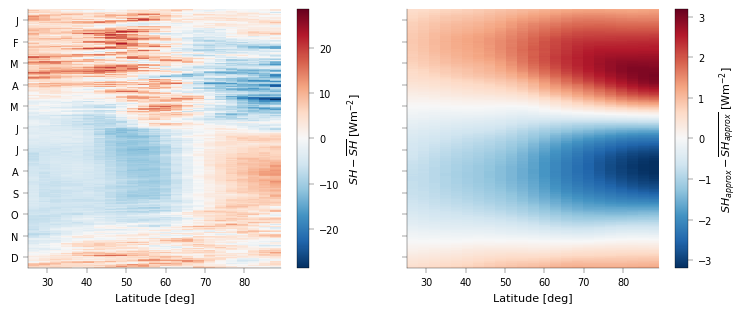

In [300]:
fig, ax = plt.subplots(1, 2, figsize=(2*im_sz*width['one_col'], im_sz*width['one_col']/ar), sharex=True, sharey=True)
plot_var_anom(None, '$SH - \overline{SH}$', 'Wm$^{-2}$', var_plot=sh_calc['av_first']-sh_calc['av_first'].mean(dim='time'), ax=ax[0])
plot_var_anom(None, '$SH_{approx} - \overline{SH_{approx}}$', 'Wm$^{-2}$', var_plot=sh_calc['final']-sh_calc['final'].mean(dim='time'), ax=ax[1]);

In [301]:
sigma_near_surf

0.9948700488727586

In [304]:
av_drag_t

0.000927483598213624